# Bayesian PI.

## Introduction


While I usually prefer the Day/Month/Year calendar format, I have to admit that the Month/Day/Year format offers something unique: it gives us 3/14, [officially recognized as $\pi$ day by the United States](https://en.wikisource.org/wiki/H._RES._224_Supporting_the_designation_of_Pi_Day,_and_for_other_purposes) and [Belize](https://www.scientificamerican.com/blog/observations/american-pi-why-the-day-belongs-to-the-u-s-and-belize/).

A common tutorial example in sampling/Monte Carlo methods is the estimation of $\pi$. 

These examples typically involve running many simulations, generating random points, and calculating how often they fall within a defined region. It is then shown that, on average, the result approximates the real value of $\pi$. However, these approaches often stop at point estimation and, at best, showing that multiple independent simulations concentrate around the real $\pi$  rather than providing a formal quantification of uncertainty. 

Naturally, this brings us to the question of uncertainty quantification, how confident are we in our estimate of  at any given point? This what Bayesian statistics  can tell you.

I have writen in my blog a series of [Bayesian statistics tutorials](https://labpresse.com/why-do-we-need-bayesian-statistics-part-i-asserting-if-a-coin-is-biased-tutorial/). This post extends that approach by applying Bayesian reasoning to the estimation of $\pi$. Just as I previously used Bayesian inference to assess bias in coin flips, here we will construct confidence intervals for  that update dynamically as more data becomes available, providing a structured way to quantify uncertainty in our estimates.



Before starting, let us import relevant libraries and set a reproducible seed. And what better seed than ππ itself? Well, unfortunately seeds need to be integers in `numpy`. Let us settle with all of its digits that I can remember off the top of my head.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
np.random.seed(314159)

In [2]:
x = np.random.uniform(-1,1,10000)
y = np.random.uniform(-1,1,10000)
rho = np.sqrt(x**2+y**2)
success = rho<1

In [3]:
def plot_square(ax,N):

    ax.scatter(x[:N][success[:N]], y[:N][success[:N]], color='darkgreen', label="Success")
    ax.scatter(x[:N][~success[:N]], y[:N][~success[:N]], color='red', marker='x', label="Failure")

    # Force square aspect ratio
    ax.set_aspect('equal')

    # Set tight boundaries for ax[0]
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

    # Set ticks only at {0, 0.5, 1}
    ax.set_xticks([-1, 0, 1])
    ax.set_yticks([-1, 0, 1])

    theta = np.linspace(0, 2*np.pi, 100)  # Angles from 0 to π
    ax.plot(np.cos(theta), np.sin(theta), 'k-', linewidth=2, label="Semicircle")    

In [4]:
def likelihood(sucess,q):
    return q**(sucess.sum())* (1-q)**((1-sucess).sum())

def posterior(data,precision=1000000):
    q = np.linspace(0,1,precision)
    dq = q[1]-q[0]
    
    #non-marginalized posterior, we comment the prior calculation as we are using a uniform one.
    nm_posterior = likelihood(data,q) #*prior(q)

    #denominator integral for marginalization
    integral = np.sum(nm_posterior)*dq

    posterior = nm_posterior/integral
    return q, posterior


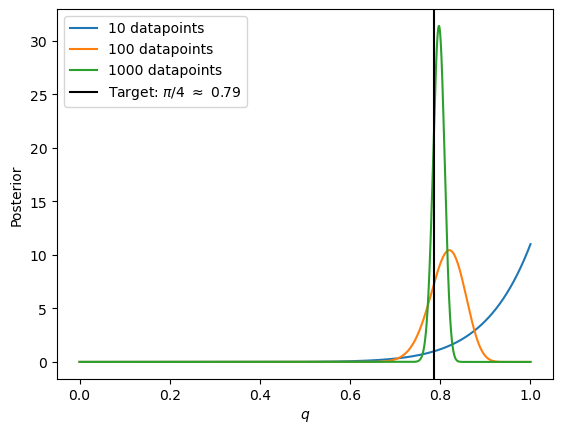

In [5]:
for j in [10,100,1000]:
    plt.plot(*posterior(success[:j]),label='{} datapoints'.format(j))
plt.axvline(np.pi/4,color = 'k',label=r'Target: $\pi$/4 $\approx$ {:.2f}'.format(np.pi/4))
plt.xlabel(r'$q$')
plt.ylabel('Posterior')
plt.legend()

In [6]:

def credible_interval(q, post, conf=0.9, init_dif=1):
    dq = q[1] - q[0]
    max_ind = post.argmax()
    dif = init_dif  # Start with an initial guess for dif
    
    # Adjust dif to find the minimal interval that meets or exceeds conf
    prev_sum = 0
    while True:
        current_sum = np.sum(post[max(0, max_ind - dif):min(len(post), max_ind + dif + 1)]) * dq
        if np.sign(current_sum-conf) != np.sign(prev_sum - conf) and prev_sum!=0:
            break
        prev_sum = current_sum
        dif += 1 if current_sum < conf else -1
    
    return q[max(0, max_ind - dif)], q[min(len(post) - 1, max_ind + dif)]

In [9]:
#Removed data block, see notebook on GitHub for full code
import imageio
import matplotlib.ticker as ticker

Ns = [1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50,75,100,150,200,250,300,350,400,500,600,700,800,900,1000]
frames=[]

initial_dif = 1000000
for i in range(len(Ns)):
    N = Ns[i]
    fig,ax =plt.subplots(1,2,figsize =(7,3.5))

    
    q,post= posterior(success[:N])
    ax[1].plot(4*q,post/4)
    fig.suptitle(f'{N:>5} datapoints', y=0.96) 

    
    ax[1].axvline(np.pi,color = 'k',label=r'Target: $\pi$')
    ax[1].set_xlabel(r'Estimated $\pi$',fontsize=15)
    ax[1].set_ylabel('Posterior',fontsize=15)
    ax[1].set_xlim(0, 4)

    conf90 = credible_interval(q,post,init_dif=initial_dif)
    initial_dif = ((conf90[1]-conf90[0])/(q[1]-q[0]))//2
    ax[1].fill_between(4*np.array(conf90),(0,0),(post.max()/np.pi,post.max()/np.pi),color='r',alpha=.25,label='95% credibility')
    ax[1].set_yticks([])

    plot_square(ax[0],N)
    ax[0].set_xlabel('Samples',fontsize=15)
    

    #plt.show()

    filename = f'gif_frames/frame_{i}.png'
    plt.tight_layout()
    plt.savefig(filename)
    frames.append(filename)

    plt.close()


output_gif = 'animation.gif'
imageio.mimsave(output_gif, [imageio.imread(frame) for frame in frames], duration=.9)


In [ ]:
inds

NameError: name 'inds' is not defined

In [ ]:
output_gif = 'animation.gif'
imageio.mimsave(output_gif, [imageio.imread(frame) for frame in frames], duration=.9)

/tmp/ipykernel_132483/3802728116.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imageio.mimsave(output_gif, [imageio.imread(frame) for frame in frames], duration=.9)


## Example -- The (allegedly) biased coin

As a first example, let's consider a coin and try to determine whether it is biased or not. The main parameter we are interested in, denoted as qq, represents the probability of the coin landing on "heads" in a single toss. To estimate the value of $q$, we will analyze the results (number of "heads") obtained from a series of $N$ coin tosses.


### The synthetic experiment

For an unbiased coin, we expect $q=1/2$​. However, unlike most experiments in biophysics (the main research interest here at Pressé lab), this one can be easily performed by the reader at home. Nevertheless, to save them from tedious labor and to illustrate the results in this post, let's create some Python code that simulates this experiment for a coin with a whose "heads" probability is denoted as $q_{GT}$​ (which we shall refer to as the ground truth).

In this code block we fixed the seed for reproducibility, this means that the Python code utilizes a fixed seed value for the random number generator before performing the coin toss simulations. If the seed remains the same, subsequent random number generation, will be consistent each time you run the code. For details see [this](https://docs.python.org/3/library/random.html).

Having this function, let us 'flip' this virtual coin for $1000$ tosses with $q_{GT}$ = 0.6, and show the results of the first $10$ tosses

The variable `data` is a [boolean](https://docs.python.org/3/c-api/bool.html) array where each element corresponds to an independent coin toss. Above we have shown the results of the first $10$ tosses, and the `True` boolean value corresponds to a "heads" result. The number of heads in the first $10$ tosses and the total number of heads can be obtained, repectively, as 

since summing a boolean array in `numpy` gives the number of `True` elements. 

One "instinctive" answer would be to give, after $N = 10$ tosses, the value $q=5/10 = .5$ thus incorrectly claiming that the biased coin is fair. After $N=1000$ tosses, however, we would instead give the value $q=613/1000 = .613$ which is closer to the ground truth value,  

### Learning the heads probability through Bayes

However, to what extent can we claim to observe the coin's bias from the data? How many coin tosses would be necessary to assert with certainty whether the coin is unbiased? To answer these questions, we will adopt the Bayesian approach to analyze the data obtained from the coin tosses and estimate the probability parameter $q$ with appropriately calculated uncertainty.

*Prior Distribution:*

Here, we use the uniform distribution over the interval [0, 1] as the prior. 
$$ p(q) = 1 \ \ \text{for} \ \ 0\leq q\leq 1;\\ p(q) = 0 \ \text{otherwise}.$$
This is often preferred to avoid biasing our results, indicating that we have no strong prior knowledge about the value of $q$. However, in other Bayesian inference scenarios, one may possess prior knowledge about the parameters of interest. In such cases, it is entirely acceptable to incorporate informative priors that align with one's understanding of the problem.
Additionally, it is common to select [conjugate priors](https://en.wikipedia.org/wiki/Conjugate_prior) for the sake of mathematical simplicity. As the sample size grows, the influence of the prior diminishes, and the posterior distribution is primarily shaped by the likelihood function. 


*Likelihood:*

If the probability of obtaining heads is $q$ and, consequentially, the probability of obtaining tails is $1-q$, the likelihood of a single datum is given as  
$$p(d|q) = \begin{cases} 
q & \text{if } d = \text{Heads} \\
1-q & \text{if } d = \text{Tails} 
\end{cases} \ .$$
So a dataset to $D = \{d_1,d_2, \ldots , d_N \}$ of $N$ independent tosses will have it's likelihood given by 
$$p(D|q) = \prod_{i=1}^N p(d_i|q) = q^{\text{\#of Heads}} (1-q)^{\text{\#of Tails}}$$
Given the data structure previously mentioned, a Python function that calculates the likelihood is given by

In [ ]:
def likelihood(data,q):
    return q**(data.sum())* (1-q)**((1-data).sum()) #the sum method treats the boolean `True' as 1 and `False' as 0.

def posterior(data,precision=.001):
    q = np.arange(0,1+precision,precision)
    dq = q[1]-q[0]
    
    #non-marginalized posterior, we comment the prior calculation as we are using a uniform one.
    nm_posterior = likelihood(data,q) #*prior(q)

    #denominator integral for marginalization
    integral = np.sum(nm_posterior)*dq

    posterior = nm_posterior/integral
    return q, posterior



*Posterior Distribution:*
The posterior distribution, denoted as $p(q | D)$, is proportional to the product of the prior and the likelihood:
$$p(q∣D) = p(q) \frac{p(D∣q)}{p(D)}\propto p(q)⋅p(D∣q)$$
Note that the evidence $P(D)$ depends on the data but not on $q$. Since the data won't change, it is merely a constant value that can be calculated by imposing that a probability distribution sums to one 
$$ \int dq \ p(q|D) = 1 \ .$$
Leading to 
$$ p(q∣D) = \frac{q^{\text{\#of Heads}} (1-q)^{\text{\#of Tails}}}{\int_0^1 dq \ q^{\text{\#of Heads}} (1-q)^{\text{\#of Tails}}}$$

Next, we will introduce a Python function that computes the posterior for an array of $q$ values between 0 and 1. Although the integral in the denominator can indeed be can be [calculated analitically](https://en.wikipedia.org/wiki/Beta_function) we'll compute it numerically in this context to avoid diving into detailed discussions not intended for this blog post.

Now in order to see how the posterior evolves with the amount of data gathered, let us plot the posterior for 10,100 and 1000 datapoints.

Implying that, as expected, a larger number of samples makes the posterior distribution becomes tighter around the real value (ground truth).

It's important to note that the Bayesian approach considers uncertainty rigorously and allows us to quantify it through probability distributions. As we collect more data (perform more coin tosses), our uncertainty about the true value of $q$ reduces, our uncertainty concerning the actual value of $q$ diminishes, yielding a more accurate estimation. 

As one might imagine, it is common in science that it is not feasible to obtain an arbitrarily big amount of data. However, it is still possible to obtain a rigorous estimation of the ground truth through the concept of credible intervals, which we will dive into now

### Credible intervals

If we focus on the posterior results previously commented, let us say that I ought to say something like: "There is a $0.95 (95\%)$ probability that $q$ lies within the interval $X$ to $Y$". In more mathematical rigor we must say and adapted for the problem at hand, we must find an interval $(X,Y)$ such that
$$ \int_X^Y dq \ p(q|D) = C \ ,$$
where $C$ is your desired credibility ($0.95$ in the sentence above).

Naturally, the credible interval is not uniquely defined and there are [many different ways to create one](https://en.wikipedia.org/wiki/Credible_interval). For our propose here, we shall find the smallest interval centered at the maximum of the posterior (sometimes refered to as the posterior mode) calculated up to a precision of $0.001$. This is done by the following function

In [ ]:
def credible_interval(data,conf=.95):
    q,post = posterior(data,precision=.001)
    dq = q[1]-q[0]
    max_ind = post.argmax()
    dif = 1 #spacing around the maximum posterior 
    while np.sum(post[max_ind-dif:max_ind+dif])*dq<conf:
        dif+=1
    return q[max_ind-dif],q[max_ind+dif]

The example below means that

In [ ]:
credible_interval(data,conf=.95),credible_interval(data,conf=.5)
    

NameError: name 'data' is not defined

the $.95$ credible interval given all of our coin tosses is $(0.582, 0.644)$ and the $0.5$ credible interval given all of our coin tosses is $(0.602, 0.624)$. Or alternatively, after these $1000$ tosses, we are lead to the conclusion that there is a $0.95$ probability that the real probability $q_{gt}$ that the coin to land on `HEADS'  is between $0.582$ and $0.644$.

Before concluding the blog post, let us visualize how the credible interval evolves with the number of datapoints

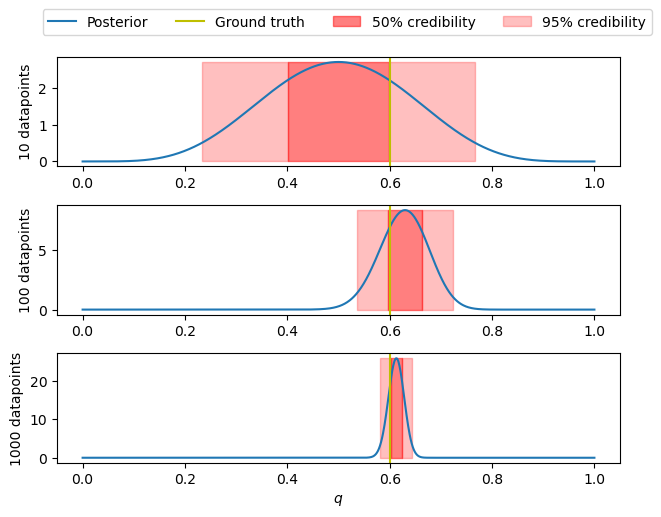

In [ ]:
fig,ax =plt.subplots(3,1)
label = True
for (axi,lim) in zip(ax,[10,100,1000]):
    q,post =posterior(data[:lim])
    axi.plot(q,post,label='Posterior')
    axi.axvline(q_GT,color = 'y',label='Ground truth')
    conf50,conf95 = credible_interval(data[:lim],conf=.5),credible_interval(data[:lim],conf=.95)
    axi.fill_between(conf50,(0,0),(post.max(),post.max()),color='r',alpha=.5,label='50% credibility')
    axi.fill_between((conf95[0],conf50[0]),(0,0),(post.max(),post.max()),color='r',alpha=.25,label='95% credibility')
    axi.fill_between((conf95[1],conf50[1]),(0,0),(post.max(),post.max()),color='r',alpha=.25)
    if label:
        fig.legend(loc=8,ncol=4,bbox_to_anchor=(.55,1.001))
        label=False
    axi.set_ylabel('{} datapoints'.format(lim))
ax[-1].set_xlabel(r'$q$')
fig.tight_layout()



Coherently with what was previously discussed, a larger number of samples makes the credible interval tighter around the real value (ground truth).

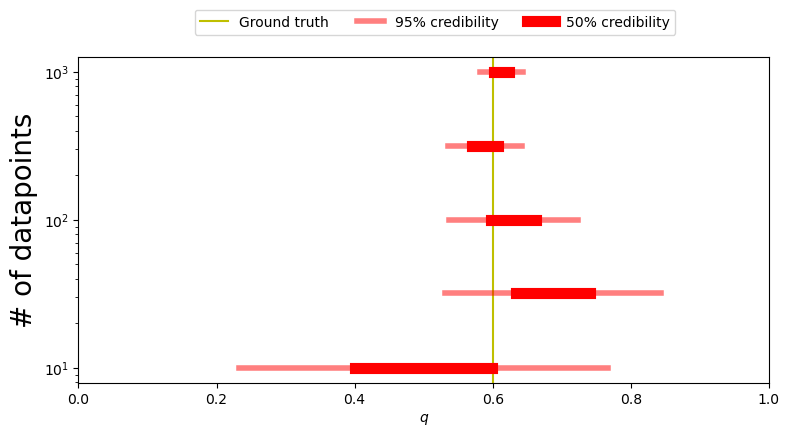

In [ ]:
fig,ax =plt.subplots(1,figsize=(8,4))

ax.axvline(q_GT,color = 'y',label='Ground truth')
label =True
for lim in [10,32,100,316,1000]:
    q,post =posterior(data[:lim])
    #axi.plot(q,post,label='Posterior')
    #axi.axvline(q_GT,color = 'y',label='Ground truth')
    conf50,conf95 = credible_interval(data[:lim],conf=.5),credible_interval(data[:lim],conf=.95)
    ax.plot(conf95,lim*np.ones(2),lw=4,color='r',alpha=.5,label='95% credibility')
    ax.plot(conf50,lim*np.ones(2),lw=8,color='r',alpha=1,label='50% credibility')
    if label:
        fig.legend(loc=8,ncol=4,bbox_to_anchor=(.55,1.001))
        label=False

ax.set_xlim(0,1)
ax.set_yscale('log') 
ax.set_ylabel('# of datapoints',fontsize=20)
ax.set_xlabel(r'$q$')
fig.tight_layout()

### Mean and standard deviation
It is  fascinating to observe the diverse array of topics that the discussion covered here. The discourse not only delved into probability theory but also encompassed areas like modeling, calculus, and numerical analysis. 
However,  it is  possible that many readers approached the problem from a different angle, suggesting that the value of $q_{GT}$ must fall between $\mu - \sigma$ and $\mu +\sigma$ where, in this case, $\mu$ is the average (fraction of heads) and $\sigma$ is defined as 
$$ \sigma = \frac{\sqrt{\sum_i^N (x_i-\mu)^2} }{N} = \frac{\sigma_D}{\sqrt{N}}$$
with $x_i$ takes the value  1 if the $i$-th toss was "heads" or 0 if the $i$-th toss was "Tails" and $\sigma_D$ being the data complete standard deviation.

Although you may have encounted this method before (If any of the readers had me as their instructor of physics lab I they may remember that we did this exact example with real coin tosses). Interestingly, when we assert that the value lies between $\mu - \sigma$ and $\mu +\sigma$ , we are essentially employing the principles of Bayesian inference, even though the rationale behind it is often left unexplained. To be more specific without diving into much detail, the interval $(\mu - \sigma,\mu +\sigma)$ approximates the $68.3 \%$ credible interval obtained through rigorous inference, but only for large number of data points $N$. The block of code below shows how this convergence happens



In [ ]:
for lim in [10,25,50,100]:
    print(lim,' datapoints:')
    mu = data[:lim].mean()
    sig = data[:lim].std()/np.sqrt(lim)
    print('mean and std      ', np.round((mu + np.array((-1,1))*sig),3))
    print('68.3 % credibility', np.round(credible_interval(data[:lim],.683),3))

10  datapoints:
mean and std       [0.342 0.658]
68.3 % credibility [0.355 0.645]
25  datapoints:
mean and std       [0.587 0.773]
68.3 % credibility [0.589 0.771]
50  datapoints:
mean and std       [0.614 0.746]
68.3 % credibility [0.615 0.745]
100  datapoints:
mean and std       [0.582 0.678]
68.3 % credibility [0.582 0.678]


This is a direct consequence of the [central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem). However, it does not replace careful Bayesian inference for several reasons, some easier to see than others.

The most evident of these reasons, as it can be seen above, emerges when dealing with a limited number of data points. In such instances, relying solely on the calculation of mean and standard deviation can yield misleading and erroneous outcomes. In fields where experiments are labor-intensive or expensive, the luxury of augmenting the dataset at will is not always viable. Moreover, some fields are grounded in observational data (*e.g.*, astronomy, sociology, economics) and, by consequence, there is a limitation on the amount of data available given by the system under study. In such cases, delving into the intricate study of probabilities inherent to Bayesian inference offers the most honest comprehension of the information concealed within the data.

Less obvious ones include:
- When the posterior is multimodal, meaning it has multiple distinct peaks (modes), the process of Bayesian inference gives answers with the adequate amount of nuance and complexity while methods that rely on single-point estimates, or the mean/mode of the posterior distribution, do not accurately capture the underlying uncertainty present in the data.
- Certain systems have a data acquisition form where the sampled values that intrinsically deviates from the mean. As happens with distributions that violate the conditions of the central limit theorem. In the near-future I will post again in this same website a clear example when that happens. In such we will observe how these naive methods fail but rigorous Bayesian inference succeeds.

## Conclusion

This blog post has given us an overview of Bayesian inference with a concrete example: finding the probability that a coin lands on heads. We constructed the Bayesian formalism by defining the prior, studying the system to obtain likelihoods, and calculate the posterior. This blog post also introduces the important (albeit not always taught in basic tutorials such as this) concept of credible interval. This was followed by a brief discussion on the use of more naive methods of statistical inference. 

In a [future blog post](https://labpresse.com/why-do-we-need-bayesian-statistics-part-ii-the-lighthouse-problem-tutorial/) we will dive into an example where these naive methods fail thus highlighting the need of an inference procedure that takes the rigorous aspect of probability to the core.

